#**Importing required libraries**

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
!pip install split-folders
import splitfolders as sf
import os

In [ ]:
import time
import torch
import copy
from PIL import Image
from torch import nn, optim
from torchvision import transforms

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import torchvision

#**Downloading inatuaralist dataset zip file from drive**

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '19EA0yl7PM8i6aQTdhH0OiEyLcTsf6hmx'

In [ ]:
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('nature_12K.zip')

#**Unzipping the content and distributing in train, validation and test folders**

In [ ]:
!apt install unzip

In [ ]:
!unzip 'nature_12K.zip'

In [ ]:
road='/content/inaturalist_12K/'
roadtrn=road+"train"
op= road+"trainvalsplit"
sf.fixed(roadtrn, op, seed=1337, fixed=100, oversample=False, group_prefix=None)

#**Preprocessing the images**

In [ ]:
#preprocessing train data
train_data = []
train_label = []
path = '/content/inaturalist_12K/trainvalsplit/train/'
items = os.listdir(path)
items.sort()

data_augmentation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


for i in range(10):
    image_folder_path = path + items[i]
    #print(image_folder_path)
    image_names = os.listdir(image_folder_path)
    for each_image in image_names:
        if each_image.endswith(".jpg"):
            full_path = image_folder_path + '/' + each_image
            image = Image.open(full_path)
            image = image.resize((224,224))
            if image.mode == 'L':
                continue
            normalized_image = data_augmentation(image)
            train_data.append((normalized_image, i))

In [ ]:
#preprocessing validation data
val_data = []
val_label = []
path = '/content/inaturalist_12K/trainvalsplit/val/'
items = os.listdir(path)
items.sort()

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for i in range(10):
    image_folder_path = path + items[i]
    #print(image_folder_path)
    image_names = os.listdir(image_folder_path)
    for each_image in image_names:
        if each_image.endswith(".jpg"):
            full_path = image_folder_path + '/' + each_image
            image = Image.open(full_path)
            image = image.resize((224,224))
            if image.mode == 'L':
                continue
            normalized_image = transform(image)
            val_data.append((normalized_image, i))

In [ ]:
classes = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 
           'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#**Constructing Convolution Neural Network**

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, dropout, channels, activation):
        super(ConvNet, self).__init__()

        self.channels = channels
        if activation == 'ReLU':
          self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
          self.activation = nn.LeakyReLU()
        elif activation == 'ELU':
          self.activation = nn.ELU()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = channels[0], kernel_size = 5)
        torch.nn.init.xavier_normal_(self.conv1.weight)
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv2 = nn.Conv2d(in_channels = channels[0], out_channels = channels[1], kernel_size = 5)
        torch.nn.init.xavier_normal_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv3 = nn.Conv2d(in_channels = channels[1], out_channels = channels[2], kernel_size = 5)
        torch.nn.init.xavier_normal_(self.conv3.weight)
        self.pool3 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv4 = nn.Conv2d(in_channels = channels[2], out_channels = channels[3], kernel_size = 5)
        torch.nn.init.xavier_normal_(self.conv4.weight)
        self.pool4 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv5 = nn.Conv2d(in_channels = channels[3], out_channels = channels[4], kernel_size = 5)
        torch.nn.init.xavier_normal_(self.conv5.weight)
        self.pool5 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features = channels[4]*2*2, out_features = 512).to(device)
        torch.nn.init.xavier_normal_(self.fc.weight).to(device)        
        self.op = nn.Linear(in_features = 512, out_features = 10).to(device)

    def forward(self, x):
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = self.pool3(self.activation(self.conv3(x)))
        x = self.pool4(self.activation(self.conv4(x)))
        x = self.pool5(self.activation(self.conv5(x)))
        
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.dropout(x)
        x = self.activation(self.fc(x))
        x = self.op(x)
        
        return x

In [ ]:
def train_model(model, criteria, optimizer, num_epochs=5, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs ))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode                
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.

            if phase == 'train':
                f = train_loader                
            else:
                f = val_loader
            for inputs, labels in f:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = 0
            epoch_acc = 0
            if phase == 'train':
                epoch_loss = running_loss / len(train_data)
                epoch_acc = running_corrects.double() /len(train_data)
            else:
                epoch_loss = running_loss / len(val_data)
                epoch_acc = running_corrects.double() / len(val_data)
            epoch_acc*=100
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#**Defining data loaders and training the model**

In [ ]:
torch.manual_seed(50)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=False)

In [ ]:
model = ConvNet(0.25, [3*i for i in [1,2,4,8,16]], 'LeakyReLU').to(device)
num_epochs = 25
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999))
model = train_model(model, criteria, optimizer, num_epochs, 'cuda')

Epoch 1/25
----------
train Loss: 2.2840 Acc: 12.8154
valid Loss: 2.2252 Acc: 16.8168
Epoch 2/25
----------
train Loss: 2.1625 Acc: 20.1845
valid Loss: 2.1208 Acc: 22.4224
Epoch 3/25
----------
train Loss: 2.0930 Acc: 23.5745
valid Loss: 2.0644 Acc: 24.7247
Epoch 4/25
----------
train Loss: 2.0389 Acc: 26.8756
valid Loss: 2.0370 Acc: 25.5255
Epoch 5/25
----------
train Loss: 2.0211 Acc: 26.9534
valid Loss: 2.0432 Acc: 25.7257
Epoch 6/25
----------
train Loss: 1.9969 Acc: 28.0427
valid Loss: 2.0010 Acc: 28.1281
Epoch 7/25
----------
train Loss: 1.9826 Acc: 29.2097
valid Loss: 1.9774 Acc: 27.5275
Epoch 8/25
----------
train Loss: 1.9627 Acc: 29.5543
valid Loss: 1.9738 Acc: 29.0290
Epoch 9/25
----------
train Loss: 1.9492 Acc: 30.0100
valid Loss: 1.9683 Acc: 27.9279
Epoch 10/25
----------
train Loss: 1.9325 Acc: 31.1215
valid Loss: 1.9508 Acc: 29.6296
Epoch 11/25
----------
train Loss: 1.9246 Acc: 31.0437
valid Loss: 1.9589 Acc: 29.8298
Epoch 12/25
----------
train Loss: 1.8994 Acc: 32.42

#**Guided Back Propogation**

In [ ]:
class guidedBackprop():
    def __init__(self,model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        self.model.eval()
        self.register_hooks()
    
    def register_hooks(self):
        def first_layer_hook_fn(module, inn, out):
            self.image_reconstruction = inn[0]
            
        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)
            
        def backward_hook_fn(module, inn, out):
            grad = self.activation_maps.pop()
            grad[grad>0] = 1
            
            positive_grad_out = torch.clamp(out[0],min=0.0)
            
            new_grad_out = positive_grad_out * grad
            
            return (new_grad_out,)
            
        modules = list(self.model.named_children())
        
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)
         
        first_layer = modules[0][1] 
        first_layer.register_backward_hook(first_layer_hook_fn)
        
    def capture(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        grad_target_map = torch.zeros(model_output.shape,
                                     dtype=torch.float)
        grad_target_map[0][target_class] = 1
        model_output.backward(grad_target_map)
        result = self.image_reconstruction.data[0].permute(1,2,0)
        return result.numpy()

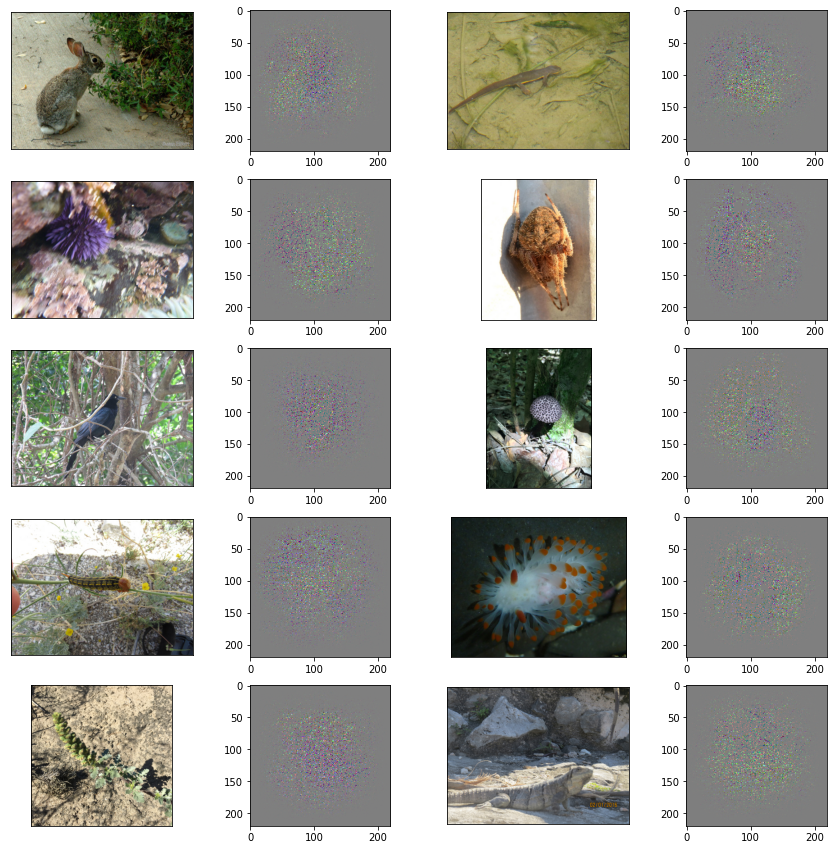

In [ ]:
def standardize(input):
    input = input - input.mean()
    input = input/input.std()
    input = input*0.1
    input = input+0.5
    input = input.clip(0,1)
    return input

image_path = ['/content/inaturalist_12K/trainvalsplit/train/Mammalia/004d9943d3a1ce516b94d25df16ce19d.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Amphibia/013722a90dd29fc6f9d87c031e7a67e0.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Animalia/00bbb141b4b82e90730cf4d6796dd219.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Arachnida/06cd8c9e2d7902f4bcf12e3ee82f199f.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Aves/0a46b188ee0b51d4a2d2eb199e3c97c6.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Fungi/063fe4d2ce0ba906f39ac512b439f772.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Insecta/01752b31ea8fd34335f60096e78f0b73.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Mollusca/059d64fa3ad87c69c4dc4df392af3378.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Plantae/1dfc3916ad58af6ce9af9fc8b36ceedd.jpg',
              '/content/inaturalist_12K/trainvalsplit/train/Reptilia/0760e1074a1266ffef76ba5c1cb41a45.jpg']

true_labels = [6, 0, 1, 2, 3, 4, 5, 7, 8, 9]

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])

i = 0
xyz = plt.figure(figsize=(15,15))
for images in image_path:
    xyz.add_subplot(5, 4, 2*i+1)
    image = Image.open(images)
    plt.imshow(image)
    image_trans = transform(image)
    image_transformed = image_trans.unsqueeze(0)
    image_transformed = image_transformed.requires_grad_()
    var1 = guidedBackprop(model.cpu())
    var2 = var1.capture(image_transformed,true_labels[i])
    var2 = standardize(var2)
    plt.xticks([])
    plt.yticks([])
    xyz.add_subplot(5, 4, 2*i+2)
    plt.imshow(var2)
    i+=1
plt.show()